In [1]:
import sklearn
import gensim
import pandas as pd 
import numpy as np
import nltk
import logging
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import preprocessing

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

dowload NLTK

In [2]:
#nltk.download('all')

Load our dataset using pandas

In [3]:
train_df = pd.read_table("C:\\Users\\chris_000\\Desktop\\train2017.tsv",names=["Id1", "Id2", "Sentiment", "Tweet"],engine="python", sep="\t+",escapechar="\\")

Use this function as a parser for our embeddings, we will use the 200 features embeddings 


In [4]:
from os.path import basename, dirname


# Preprocess pretrained text vectors
# and stores them in a suitable format (.npy)

def txtvec2npy(v_path, base_path_save, dest_filename):
    """
    Preprocess pretrained text vectors and stores them in a suitable format
    :param v_path: Path to the text vectors file.
    :param base_path_save: Path where the formatted vectors will be stored.
    :param dest_filename: Filename of the formatted vectors.
    """
    word_vecs = dict()
    print ("Loading vectors from %s" % v_path)
    vectors = [x[:-1] for x in open(v_path).readlines()]
    if len(vectors[0].split()) == 2:
        signature = vectors.pop(0).split()
        dimension = int(signature[1])
        n_vecs = len(vectors)
        assert int(signature[0]) == n_vecs, 'The number of read vectors does not match with the expected one (read %d, expected %d)' % (n_vecs, int(signature[0]))
    else:
        n_vecs = len(vectors)
        dimension = len(vectors[0].split()) - 1

    print ("Found %d vectors of dimension %d in %s" % (n_vecs, dimension, v_path))
    i = 0
    for vector in vectors:
        v = vector.split()
        vec = np.asarray(v[-dimension:], dtype='float32')
        word = ' '.join(v[0: len(v) - dimension])
        word_vecs[word] = vec
        i += 1
        if i % 100000 == 0:
            print ("Processed %d vectors (%.2f %%)\r" % (i, 100 * float(i) / n_vecs),)

    print ("")
    # Store dict
    print ("Saving word vectors in %s" % (base_path_save + dest_filename + '.npy'))
    np.save(base_path_save + dest_filename + '.npy', word_vecs)
    print ("")
    return word_vecs

Load the embeddings file (this also saves the file to the specified path)

In [5]:
v_path = "C:\\Users\\chris_000\\Desktop\\datastories.twitter.200d.txt"
base_path_save = "C:\\Users\\chris_000\\Desktop\\"
dest_filename = "word_emb"
word_vec=txtvec2npy(v_path, base_path_save, dest_filename)

Loading vectors from C:\Users\chris_000\Desktop\datastories.twitter.200d.txt
Found 658125 vectors of dimension 200 in C:\Users\chris_000\Desktop\datastories.twitter.200d.txt
('Processed 100000 vectors (15.19 %)\r',)
('Processed 200000 vectors (30.39 %)\r',)
('Processed 300000 vectors (45.58 %)\r',)
('Processed 400000 vectors (60.78 %)\r',)
('Processed 500000 vectors (75.97 %)\r',)
('Processed 600000 vectors (91.17 %)\r',)

Saving word vectors in C:\Users\chris_000\Desktop\word_emb.npy



In [6]:
train_df= train_df[['Sentiment','Tweet']]
train_df.head()

,Sentiment,Tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,negative,Iranian general says Israel's Iron Dome can't ...
4,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."


Split the dataset into train and test sets. This test set will act as our validation set and we will select the best performing
classifiers for the final test set evaluation

In [7]:
msg_train, msg_test, label_train, label_test = train_test_split(train_df['Tweet'], train_df['Sentiment'], test_size=0.2,random_state = 32)

#create numeric categories using the LabelEncoder and fit-transorm pipeline
le = preprocessing.LabelEncoder()
le.fit(label_train)
label_train = le.transform(label_train)
label_test = le.transform(label_test)

print(label_train)
print(label_test)

[1 2 2 ... 2 2 2]
[1 1 0 ... 2 2 1]


This function tokenizes and creates embeddings. We also filter stopwords because we would likely
end up with some tweets having generic word embeddings for vectors such as "the".
The final array for every tweet is the mean array of its tweets, otherwise we just create a zeros array of the same size
(in case of a tweet not having any word in our embeddings file). We also have a similar function for creating vectors from lexica

In [8]:
def create_embeddings_vectors(msg,emb_size):
    tokenized_tweets = []
    for row in msg:
        s = row.translate(None, string.punctuation)
        tokens = word_tokenize(s.decode('utf-8'))
        filtered_tweet = [w.lower() for w in tokens if not w in stopwords.words('english')]
        tokenized_tweets.append(filtered_tweet)
    mean_tweets = []
    for tweet in tokenized_tweets:
        list_arr = []
        for word in tweet:
            if word in word_vec:
                list_arr.append(word_vec[word])
        if list_arr == []:
            mean_arr = np.zeros(emb_size)
            #meantw =np.mean( mean_arr, axis=0 )
            mean_tweets.append(meantw)
        else:
            mean_arr= np.array(list_arr)
            meantw =np.mean( mean_arr, axis=0 )
            mean_tweets.append(meantw) 
    return mean_tweets

import scipy

def create_additional_vectors(msg,dict_list,dictionaries):
    tokenized_tweets = []
    for row in msg:
        s = row.translate(None, string.punctuation)
        tokens = word_tokenize(s.decode('utf-8'))
        filtered_tweet = [w.lower() for w in tokens if not w in stopwords.words('english')]
        tokenized_tweets.append(filtered_tweet)
    vectors = []
    for tweet in tokenized_tweets:
        newfeatures = []
        for N in dictionaries_list: 
            list_arr = []
            dict = dictionaries[N]
            for word in tweet:
                if word in dict:
                    list_arr.append(dict[word])
            if list_arr == []:
                mean_arr = 0
                newfeatures.append(mean_arr)
            else:
                meantw =scipy.mean(list_arr)
                newfeatures.append(meantw)
                
        newfeatures = np.array(newfeatures)
        vectors.append(newfeatures)
    return vectors

Load the lexica files

In [9]:
import os
import io

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

base = 'C:\\Users\\chris_000\\Desktop\\lexica\\'
dictionaries = {}
dictionaries_list = []
for filename in os.listdir(base):
    #print filename
    dict_name = filename.split('.')[0]
    #print dict_name
    embeddings_dict = {}
    f = io.open(base+filename, "r", encoding="utf-8")
    for i, line in enumerate(f):
        values = line.split()
        #print values
        word = values[0]
        if len(values) == 1:
            continue
        if isfloat(values[1]):
            valence = np.asarray(values[1], dtype='float32')
            embeddings_dict[word] = valence
        else:
            continue
    dictionaries[dict_name] = embeddings_dict
    dictionaries_list.append(dict_name)

Create the three different vectors we will need (bow, tdfid, embeddings) using the sklearn vectorizers and our own for the embeddings

In [10]:
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(msg_train)
X_test = vectorizer.transform(msg_test)

vectorizer_2 = TfidfVectorizer()
X_train_2 = vectorizer_2.fit_transform(msg_train)
X_test_2 = vectorizer_2.transform(msg_test)

X_train_3 = create_embeddings_vectors(msg_train,200)
X_test_3 = create_embeddings_vectors(msg_test,200)

In [11]:
test_vectors =create_additional_vectors(msg_test,dictionaries_list,dictionaries)
train_vectors =create_additional_vectors(msg_train,dictionaries_list,dictionaries)

for vector in test_vectors:
    np.nan_to_num(vector,copy=False)
for vector in train_vectors:
    np.nan_to_num(vector,copy=False)

X_train_4=[np.concatenate([a,b]) for a, b in zip(X_train_3, train_vectors)]
X_test_4=[np.concatenate([a,b]) for a, b in zip(X_test_3, test_vectors)]

In [12]:
'''
index=0
for x in X_train_3:
    if x.size != 200:
        print x
        print index
    index+=1
index=0
for x in X_test_3:
    if x.size != 200:
        print x
        print index
    index+=1  
'''
        

'\nindex=0\nfor x in X_train_3:\n    if x.size != 200:\n        print x\n        print index\n    index+=1\nindex=0\nfor x in X_test_3:\n    if x.size != 200:\n        print x\n        print index\n    index+=1  \n'

Knn classifier: we fit each kind of vector in our knn classifiers of varying neighbors.
Note tha knn is prone to curse of dimensionality and has trouble handling large feature vectors(at least the vanilla version) mainly due to the fact that Eucleidian distance matte
rs less and less the higher the dimensions.
We will see that there is a difference in both Accuracy and F1 metrics when using SVM (SVM is better)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

nbors = [1,3,5,10,20,50,75,100]
bow_predict_acc=[]
bow_f1=[]
tfidf_predict_acc = []
tfidf_f1=[]
emb_pred_acc = []
emb_f1=[]
embN_pred_acc = []
embN_f1=[]
for n in nbors:

    knn = KNeighborsClassifier(n_neighbors=n)

    classifier = knn
    classifier.fit(X_train, label_train)
    predictions = classifier.predict(X_test)
    bow_predict_acc.append(metrics.accuracy_score(label_test, predictions))
    bow_f1.append(f1_score(label_test, predictions, average='macro')) 
    #print "bow",n,metrics.accuracy_score(label_test, predictions) 

    classifier.fit(X_train_2, label_train)
    predictions = classifier.predict(X_test_2)
    tfidf_predict_acc.append(metrics.accuracy_score(label_test, predictions))
    tfidf_f1.append(f1_score(label_test, predictions, average='macro'))
    #print "tfidf",n,metrics.accuracy_score(label_test, predictions)
    
    classifier.fit(np.array(X_train_3), label_train)
    predictions = classifier.predict(np.array(X_test_3))
    emb_pred_acc.append(metrics.accuracy_score(label_test, predictions))
    emb_f1.append(f1_score(label_test, predictions, average='macro'))
    #print "emb",n,metrics.accuracy_score(label_test, predictions)
    
    classifier.fit(np.array(X_train_4), label_train)
    predictions = classifier.predict(np.array(X_test_4))
    embN_pred_acc.append(metrics.accuracy_score(label_test, predictions))
    embN_f1.append(f1_score(label_test, predictions, average='macro'))
    #print "emb",n,metrics.accuracy_score(label_test, predictions)

C:\Users\chris_000\Anaconda2\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Create the arrays for our results using dataframes. We also create heatmaps for both metrics.
The best classifer in terms of Accuracy is the TfIdf with n=100.
The best classifier for F1 score is the embeddings with n= 10.

In [14]:
neigh = np.array(nbors)
bow = np.array(bow_predict_acc)
tfidf = np.array(tfidf_predict_acc)
emb = np.array(emb_pred_acc)
embN = np.array(embN_pred_acc)

bow_f1 = np.array(bow_f1)
tfidf_f1 = np.array(tfidf_f1)
emb_f1 = np.array(emb_f1)
embN_f1 = np.array(embN_f1)

results = pd.DataFrame({'Neighbours':neigh,'Bow':bow,'TfIdf':tfidf,'Embeddings':emb,'Embeddings+N':embN})
results = results[['Neighbours','Bow','TfIdf','Embeddings','Embeddings+N']]

results_f1 = pd.DataFrame({'Neighbours':neigh,'Bow':bow_f1,'TfIdf':tfidf_f1,'Embeddings':emb_f1,'Embeddings+N':embN_f1})
results_f1 = results_f1[['Neighbours','Bow','TfIdf','Embeddings','Embeddings+N']]                      


In [15]:
results

,Neighbours,Bow,TfIdf,Embeddings,Embeddings+N
0,1,0.475503,0.506859,0.505612,0.492963
1,3,0.486371,0.510244,0.519865,0.511491
2,5,0.489221,0.539462,0.539640,0.538571
3,10,0.478888,0.564582,0.564760,0.560663
4,20,0.478354,0.585605,0.574025,0.563335
5,50,0.463923,0.598610,0.575628,0.560128
6,75,0.451986,0.600748,0.570640,0.549795
7,100,0.442722,0.602530,0.570640,0.549795


In [16]:
results_f1

,Neighbours,Bow,TfIdf,Embeddings,Embeddings+N
0,1,0.405766,0.471932,0.468509,0.461204
1,3,0.419775,0.480042,0.492463,0.486769
2,5,0.389447,0.501024,0.507374,0.506572
3,10,0.348594,0.502227,0.524523,0.519642
4,20,0.318986,0.509538,0.519657,0.519089
5,50,0.275810,0.492645,0.510883,0.500392
6,75,0.251938,0.478134,0.499892,0.486465
7,100,0.231002,0.471134,0.493817,0.485466


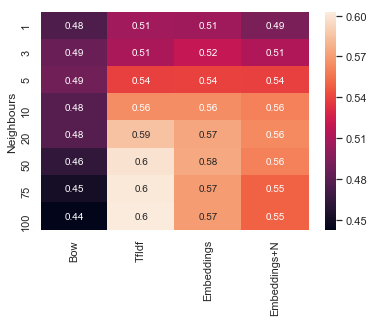

In [17]:
import seaborn as sns;sns.set()


%matplotlib inline
results=results.set_index('Neighbours')
sns.heatmap(results, annot=True)

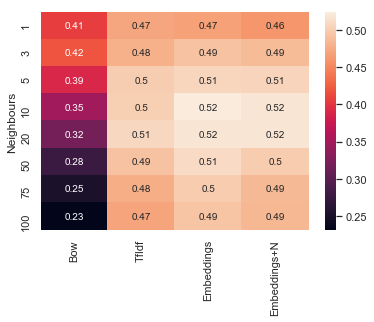

In [18]:
results_f1=results_f1.set_index(['Neighbours'])
sns.heatmap(results_f1, annot=True)

We wil now perform a similar grid search for the SVM. We are using linear SVC since non-linear (RBF) kernels scale terribly.
The accuracy and f1 score are both better than knn. Also, we find that simple bag of words performs the best for Acc and F1 using
hinge and squared hinge loss respectively for c = 0.1

In [19]:
from sklearn.svm import SVC, LinearSVC

c_param = [1, 2, 0.8, 0.5, 0.3, 0.1]
loss = ['hinge','squared_hinge']
svm_bow_predict_acc=[]
svm_bow_f1=[]
svm_tfidf_predict_acc = []
svm_tfidf_f1=[]
svm_emb_pred_acc = []
svm_emb_f1=[]
svm_embN_pred_acc = []
svm_embN_f1=[]

for c in c_param:
    for l in loss:
        
        clf = LinearSVC(C=c,loss=l)
        classifier = clf

        classifier.fit(X_train, label_train)
        svm_predictions = classifier.predict(X_test)
        svm_bow_predict_acc.append(metrics.accuracy_score(label_test, svm_predictions))
        svm_bow_f1.append(f1_score(label_test, svm_predictions, average='macro')) 
        #print "bow",c,loss,metrics.accuracy_score(label_test, svm_predictions) 

        classifier.fit(X_train_2, label_train)
        svm_predictions_ = classifier.predict(X_test_2)
        svm_tfidf_predict_acc.append(metrics.accuracy_score(label_test, svm_predictions_))
        svm_tfidf_f1.append(f1_score(label_test, svm_predictions_, average='macro'))
        #print "tfidf",c,loss,metrics.accuracy_score(label_test, svm_predictions_)

        classifier.fit(np.array(X_train_3), label_train)
        svm_predictions = classifier.predict(np.array(X_test_3))
        svm_emb_pred_acc.append(metrics.accuracy_score(label_test, svm_predictions))
        svm_emb_f1.append(f1_score(label_test, svm_predictions, average='macro'))
        #print "emb",c,loss,metrics.accuracy_score(label_test, svm_predictions)
        
        classifier.fit(np.array(X_train_4), label_train)
        svm_predictions = classifier.predict(np.array(X_test_4))
        svm_embN_pred_acc.append(metrics.accuracy_score(label_test, svm_predictions))
        svm_embN_f1.append(f1_score(label_test, svm_predictions, average='macro'))
        #print "emb",c,loss,metrics.accuracy_score(label_test, svm_predictions)



In [20]:
index = ['1_hinge','1_sq_hinge', '2_hinge','2_sq_hinge', '0.8_hinge','0.8_sq_hinge', '0.5_hinge','0.5_sq_hinge', '0.3_hinge','0.3_sq_hinge', '0.1_hinge','0.1_sq_hinge']
index = np.array(index)
svm_bow = np.array(svm_bow_predict_acc)
svm_tfidf = np.array(svm_tfidf_predict_acc)
svm_emb = np.array(svm_emb_pred_acc)
svm_embN = np.array(svm_embN_pred_acc)

svm_bow_f1 = np.array(svm_bow_f1)
svm_tfidf_f1 = np.array(svm_tfidf_f1)
svm_emb_f1 = np.array(svm_emb_f1)
svm_embN_f1 = np.array(svm_embN_f1)

svm_results = pd.DataFrame({'Bow':svm_bow,'TfIdf':svm_tfidf,'Embeddings':svm_emb,'Embeddings+N':svm_embN},index=index)
svm_results = svm_results[['Bow','TfIdf','Embeddings','Embeddings+N']]

svm_results_f1 = pd.DataFrame({'Bow':svm_bow_f1,'TfIdf':svm_tfidf_f1,'Embeddings':svm_emb_f1,'Embeddings+N':svm_embN_f1},index=index)
svm_results_f1 = svm_results_f1[['Bow','TfIdf','Embeddings','Embeddings+N']] 

In [21]:
svm_results

,Bow,TfIdf,Embeddings,Embeddings+N
1_hinge,0.648673,0.674862,0.634242,0.605915
1_sq_hinge,0.639409,0.666667,0.637092,0.628006
2_hinge,0.635489,0.668805,0.634242,0.599323
2_sq_hinge,0.628897,0.656155,0.637092,0.548370
0.8_hinge,0.651523,0.677712,0.633529,0.628541
0.8_sq_hinge,0.644753,0.672011,0.636914,0.585605
0.5_hinge,0.660966,0.670230,0.632817,0.580438
0.5_sq_hinge,0.648851,0.674149,0.637271,0.605024
0.3_hinge,0.670764,0.658828,0.633173,0.593087
0.3_sq_hinge,0.659719,0.672724,0.637271,0.600214


In [22]:
svm_results_f1

,Bow,TfIdf,Embeddings,Embeddings+N
1_hinge,0.617909,0.634169,0.582972,0.556410
1_sq_hinge,0.607740,0.635319,0.596241,0.572229
2_hinge,0.605110,0.636961,0.583099,0.541538
2_sq_hinge,0.598870,0.626889,0.596512,0.513691
0.8_hinge,0.620476,0.635866,0.579483,0.569483
0.8_sq_hinge,0.612744,0.639359,0.595836,0.553900
0.5_hinge,0.628045,0.611558,0.578390,0.551678
0.5_sq_hinge,0.617044,0.637722,0.596389,0.563940
0.3_hinge,0.636702,0.583197,0.577070,0.563004
0.3_sq_hinge,0.627235,0.631411,0.596176,0.549651


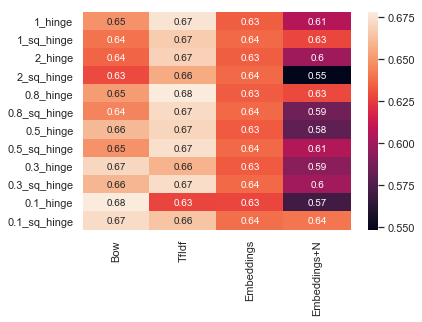

In [23]:
sns.heatmap(svm_results, annot=True)

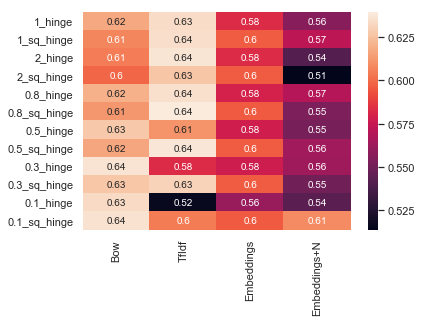

In [24]:
sns.heatmap(svm_results_f1, annot=True)

For non linear kernels we will only use word embeddings since for high dimensional vectors and lots of features RBF kernel is very costly 

In [25]:
classifier = SVC(gamma = 'auto')
svm_emb_pred_acc = []
svm_emb_f1 = []

classifier.fit(np.array(X_train_3), label_train)
svm_predictions = classifier.predict(np.array(X_test_3))
svm_emb_pred_acc.append(metrics.accuracy_score(label_test, svm_predictions))
svm_emb_f1.append(f1_score(label_test, svm_predictions, average='macro'))
#print "emb",c,loss,metrics.accuracy_score(label_test, svm_predictions)

classifier.fit(np.array(X_train_4), label_train)
svm_predictions = classifier.predict(np.array(X_test_4))
svm_emb_pred_acc.append(metrics.accuracy_score(label_test, svm_predictions))
svm_emb_f1.append(f1_score(label_test, svm_predictions, average='macro'))
#print "emb",c,loss,metrics.accuracy_score(label_test, svm_predictions)

C:\Users\chris_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Both metrics are worse than the liniear svm and the algorithm is way slower

In [26]:
svm_emb_pred_acc

[0.6190985212898629, 0.40905041867094244]

In [27]:
svm_emb_f1

[0.5305511827034275, 0.19353479158764275]

Grid-Search/Analysis is now done, we will chose the best performing classifiers and use them to predict the test_set provided.
We do this to avoid overfitting since using the final test set in the grid search can cause us to select parameters which fit it best thus overfitting the test set.
The ones we will use are the best parameters for each metric (Acc,F1) and each one of the algorithms (KNN, SVM)
For KNN we have TfIdf N=100 and Embeddings N=10
For SVC we have 0.8_hinge TfIdf and 0.8_sq_hinge TfIdf


In [28]:
base = 'C:\\Users\\chris_000\\Desktop\\'
f = io.open(base+'SemEval2017_task4_subtaskA_test_english_gold.txt', "r", encoding="utf-8")
sentiments = []
for i, line in enumerate(f):
    values = line.split()
    #print values
    sentiments.append(values[1])
test_df = pd.read_table("C:\\Users\\chris_000\\Desktop\\test2017.tsv",names=["Id1", "Id2", "Sentiment", "Tweet"],engine="python", sep="\t+",escapechar="\\")


test_df=test_df.assign(Label=sentiments)

msg_test, msg ,label_test_final,lbl = train_test_split(test_df['Tweet'], test_df['Label'],test_size = 0,shuffle = False)

#create numeric categories using the LabelEncoder and fit-transorm pipeline
#le = preprocessing.LabelEncoder()
#le.fit(label_test_final)
label_test_final = le.transform(label_test_final)

print(label_test_final)

X_test_2_final = vectorizer_2.transform(msg_test)

X_test_3_final = create_embeddings_vectors(msg_test,200)

[1 2 2 ... 1 1 1]


In [29]:
clf = LinearSVC(C=0.8,loss='hinge')
classifier = clf
svm_tfidf_predict_acc = []
svm_tfidf_f1 = []
   
classifier.fit(X_train_2, label_train)
svm_predictions_ = classifier.predict(X_test_2_final)
svm_tfidf_predict_acc.append(metrics.accuracy_score(label_test_final, svm_predictions_))
svm_tfidf_f1.append(f1_score(label_test_final, svm_predictions_, average='macro'))

clf = LinearSVC(C=0.8,loss='squared_hinge')
classifier = clf
classifier.fit(X_train_2, label_train)
svm_predictions_ = classifier.predict(X_test_2_final)
svm_tfidf_predict_acc.append(metrics.accuracy_score(label_test_final, svm_predictions_))
svm_tfidf_f1.append(f1_score(label_test_final, svm_predictions_, average='macro'))



In [30]:
tfidf_predict_acc = []
tfidf_f1=[]
emb_pred_acc = []
emb_f1=[]

In [31]:
label_test_final

array([1, 2, 2, ..., 1, 1, 1], dtype=int64)

In [32]:
knn = KNeighborsClassifier(n_neighbors=10)    
classifier = knn    
classifier.fit(np.array(X_train_3), label_train)
predictions = classifier.predict(np.array(X_test_3_final))
emb_pred_acc.append(metrics.accuracy_score(label_test_final, predictions))
emb_f1.append(f1_score(label_test_final, predictions, average='macro'))

In [33]:
knn = KNeighborsClassifier(n_neighbors=100)
classifier = knn
classifier.fit(X_train_2, label_train)
predictions = classifier.predict(X_test_2_final)
tfidf_predict_acc.append(metrics.accuracy_score(label_test_final, predictions))
tfidf_f1.append(f1_score(label_test_final, predictions, average='macro'))
#print "tfidf",n,metrics.accuracy_score(label_test, predictions)

we will also run the rbf kernel svm of embeddings since it is better than both knn classifiers

In [34]:
classifier = SVC(gamma = 'auto')
svmrbf_emb_pred_acc = []
svmrbf_emb_f1 = []

classifier.fit(np.array(X_train_3), label_train)
svm_predictions = classifier.predict(np.array(X_test_3_final))
svmrbf_emb_pred_acc.append(metrics.accuracy_score(label_test_final, svm_predictions))
svmrbf_emb_f1.append(f1_score(label_test_final, svm_predictions, average='macro'))
#print "emb",c,loss,metrics.accuracy_score(label_test, svm_predictions)


In [35]:
index = ['knn_10_emb','knn_100_tfidf','svm_0.8_hinge_tfidf','svm_0.8_squared_hinge_tfidf','svm_rbf_emb']
index = np.array(index)
results = [emb_pred_acc[0],tfidf_predict_acc[0],svm_tfidf_predict_acc[0],svm_tfidf_predict_acc[1],svmrbf_emb_pred_acc[0]]
results_f1 = [emb_f1[0],tfidf_f1[0],svm_tfidf_f1[0],svm_tfidf_f1[1],svmrbf_emb_f1[0]]
final_results = pd.DataFrame({'Accuracy':results,'F1_score':results_f1},index=index)


In [36]:
final_results

,Accuracy,F1_score
knn_10_emb,0.539401,0.528141
knn_100_tfidf,0.459297,0.381404
svm_0.8_hinge_tfidf,0.565939,0.537589
svm_0.8_squared_hinge_tfidf,0.551937,0.535340
svm_rbf_emb,0.591013,0.554032


We can see that the RBF kernel SVM performs the best on our test data. This means that it's more robust and didn't overfit our previous test set (validation set) like the knn with n=100 did.Overall SVM seems to be the better choice for our problem and if not for the bad scalling, SVM with RBF kernel would be the best performing algorithm. However, one might chose the linear version of SVM due to better performance without sacrificing too much regarding metric evaluation. 